In [405]:
import os
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/halladj/data_set/main/"
#LAPTOPS_PATH = os.path.join("datasets", "labtops")
LAPTOPS_PATH = os.path.join("test_datasets", "labtops")

#LAPTOPS_URL = DOWNLOAD_ROOT + "datasets/laptops/done.csv"
LAPTOPS_URL = DOWNLOAD_ROOT + "test_datasets/laptops/inhanced_test.csv"

def fetch_laptops_data(laptops_url = LAPTOPS_URL, laptops_path = LAPTOPS_PATH):
    os.makedirs(laptops_path, exist_ok= True)
    #file_path = os.path.join(laptops_path, "done.csv")
    file_path = os.path.join(laptops_path, "inhanced_test.csv")
    urllib.request.urlretrieve(laptops_url, file_path)
    
import pandas as pd
import numpy as np

def load_laptops_data(laptops_path = LAPTOPS_PATH):
    #csv_path = os.path.join(laptops_path, "done.csv")
    csv_path = os.path.join(laptops_path, "inhanced_test.csv")
    return pd.read_csv(csv_path, dtype= category_cols)    

In [406]:
category_cols = {item: 'category' for item in ['ram_type', 'cpu_number_identifier', 'brand', 'cpu_family'
                                               , 'cpu_modifier',  'gpu_brand', 'gpu_number_identifier', 'gpu_words_identifier',
                                               'screen_resolution', 'cpu_brand']}

fetch_laptops_data()
laptops= load_laptops_data()

laptops["state"].replace(["new", "used"], [True, False], inplace=True)
laptops["touch_screen"].replace([1, 0], [True, False], inplace=True)
laptops["anti_glare"].replace([1, 0], [True, False], inplace=True)
#####
#laptops["gpu_vram"].replace([0], [None], inplace=True)
#laptops["gpu_brand"].replace([0], [None], inplace=True)
#laptops["gpu_number_identifier"].replace([0], [None], inplace=True)
#laptops["gpu_words_identifier"].replace([0], [None], inplace=True)
#####

laptops["cpu_frequency"].replace([0, np.nan], inplace=True)
laptops["ram_frequency"].replace([0, np.nan], inplace=True)

laptops.dtypes
column_label= laptops["price"]
laptops=laptops.drop(columns=["price"])

In [407]:
laptops_category= laptops[['ram_type', 'brand', 'cpu_family', "cpu_generation",
                           'cpu_modifier', 'gpu_brand', 'gpu_number_identifier', 
                           'gpu_words_identifier','screen_resolution', 'cpu_brand']]
#remove cpu generation
laptops_num= laptops.drop(columns=['ram_type','cpu_number_identifier', 'brand', 'cpu_family',
                                   'cpu_modifier',  'gpu_brand', 'gpu_number_identifier', 
                                   'gpu_words_identifier','screen_resolution', 'cpu_brand'])

#laptops_num= laptops_num.drop(columns=['Back-light', 'gpu_frequency'])
laptops_num= laptops_num.drop(columns=['Back-light'])

In [408]:
print("Shape of the data-set: ", laptops.shape)

Shape of the data-set:  (501, 24)


In [409]:
######
## ONEHOTENCODING
######
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
onehot_encoder= OneHotEncoder()
laptops_category_encoded= onehot_encoder.fit_transform(laptops_category)

In [410]:
######
## NORMALIZATION
######
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

num_pipeline_full= Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("MinMax_scaler", MinMaxScaler()),
    ("standered_scaler", StandardScaler())
])

num_pipeline_minmax= Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("MinMax_scaler", MinMaxScaler()),
])

num_pipeline_standard= Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("standered_scaler", StandardScaler())
])

num_pipeline_imputer= Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])


laptops_num_transformed= num_pipeline_imputer.fit_transform(laptops_num)

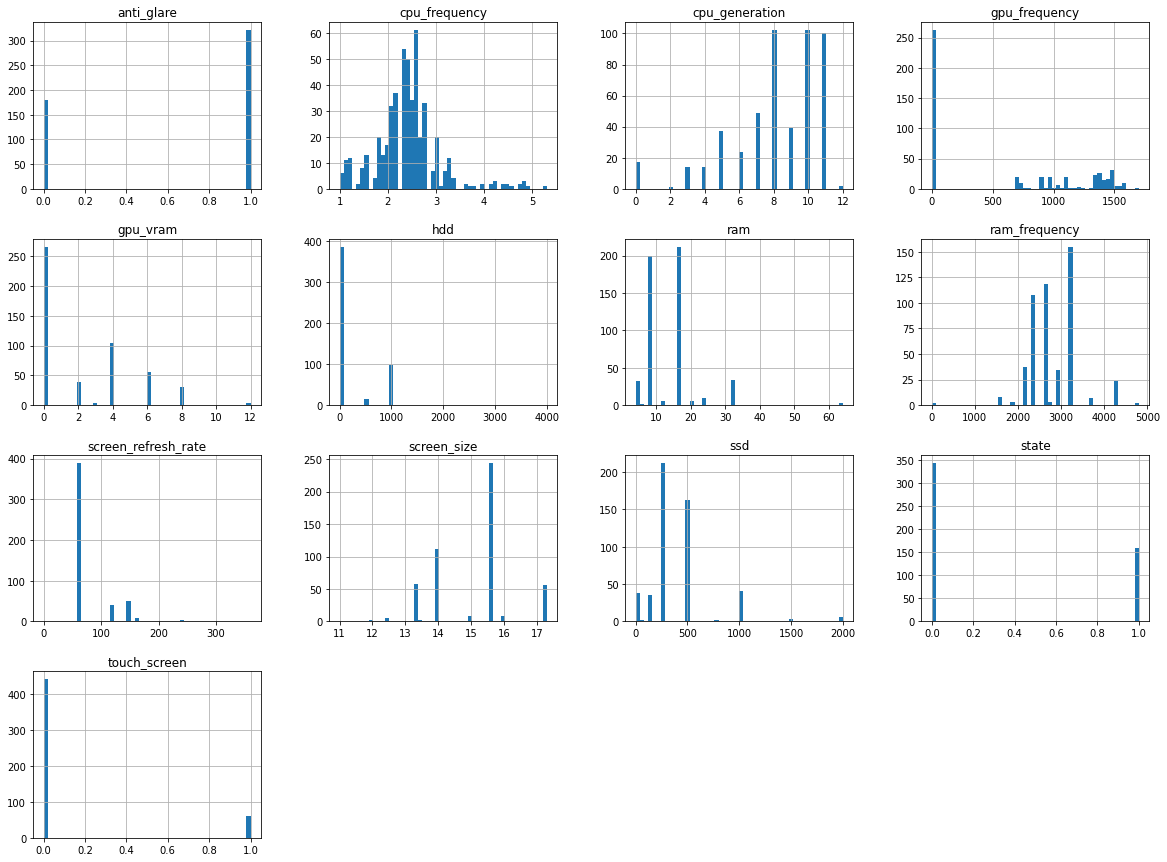

In [411]:
#####
## DATA VISUALIZING
#####
%matplotlib inline
import matplotlib.pyplot as plt


pd.DataFrame(laptops_num_transformed, columns=list(laptops_num.columns)).hist(bins=50, figsize= (20, 15))
plt.show()

In [412]:
category_att= list(category_cols.keys())
num_att= list(laptops_num.columns)


from sklearn.compose import ColumnTransformer

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_full, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])

column_label= column_label.values.reshape(501,1)
laptops_prepared= full_pipeline.fit_transform(laptops)

In [413]:
#####
## DATA SPLIT
#####
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_percentage_error, median_absolute_error
                                           
from sklearn.model_selection import train_test_split

def print_matrices(y_test, predictions):
    print("Explained Variance Score: %.2f" % explained_variance_score(y_test, predictions))
    print("Max Error: %.2f" % max_error(y_test, predictions))
    print("Mean Absolute Error: %.2f" % mean_absolute_error(y_test, predictions))
    print("Mean Squared Error: %.2f" % mean_squared_error(y_test, predictions))
    print("Mean Absolute Precentage Error: %.2f" % mean_absolute_percentage_error(y_test, predictions))
    print("Median Absolute Error: %.2f" % median_absolute_error(y_test, predictions))
    print("R2 Score : %.2f" % r2_score(y_test, predictions))
    
    

x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)

In [414]:
######
## Least Squars
######
from sklearn.linear_model import LinearRegression


full_pipeline= ColumnTransformer([
    ("num", num_pipeline_full, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)
####### pick random_state equal to 1 and 3 LOL
reg = LinearRegression()
reg.fit(x_train, y_train)

prediction= reg.predict(x_test)


print_matrices(y_test, prediction)

Explained Variance Score: 0.77
Max Error: 314242.29
Mean Absolute Error: 26982.79
Mean Squared Error: 2298951640.16
Mean Absolute Precentage Error: 0.23
Median Absolute Error: 14550.42
R2 Score : 0.77


In [415]:
######
## RidgeCV

######
from sklearn.linear_model import RidgeCV


full_pipeline= ColumnTransformer([
    ("num", num_pipeline_minmax, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)


reg= RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
reg.fit(x_train, y_train)

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

Explained Variance Score: 0.79
Max Error: 322567.15
Mean Absolute Error: 25396.40
Mean Squared Error: 2150815835.42
Mean Absolute Precentage Error: 0.22
Median Absolute Error: 14368.30
R2 Score : 0.79


In [416]:
######
## ElasticNetCV
######
from sklearn.linear_model import ElasticNetCV

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_imputer, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)


reg= ElasticNetCV(cv=4, random_state=0)
reg.fit(x_train, y_train.ravel())

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

Explained Variance Score: 0.46
Max Error: 491416.79
Mean Absolute Error: 42310.93
Mean Squared Error: 5470591582.74
Mean Absolute Precentage Error: 0.37
Median Absolute Error: 21536.17
R2 Score : 0.45


In [417]:
######
## LarsCV
######
from sklearn.linear_model import LarsCV

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_standard, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)



reg= LarsCV(cv=4)
reg.fit(x_train.todense(), y_train)

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

/home/hambz/Uni/python/workspace/workshop_trail/lib/python3.10/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/home/hambz/Uni/python/workspace/workshop_trail/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/s

Explained Variance Score: 0.66
Max Error: 385425.46
Mean Absolute Error: 32727.78
Mean Squared Error: 3400094190.34
Mean Absolute Precentage Error: 0.27
Median Absolute Error: 18825.46
R2 Score : 0.66


/home/hambz/Uni/python/workspace/workshop_trail/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 202 iterations, i.e. alpha=8.699e+07, with an active set of 156 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/hambz/Uni/python/workspace/workshop_trail/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 204 iterations, i.e. alpha=5.275e+07, with an active set of 158 regressors, and the smallest cholesky pivot element being 9.884e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/hambz/Uni/python/workspace/workshop_trail/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 

In [418]:
######
## LassoCV
######
from sklearn.linear_model import LassoCV

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_full, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)


reg= LassoCV(cv=4, n_alphas=50)
reg.fit(x_train.todense(), y_train.ravel())

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

/home/hambz/Uni/python/workspace/workshop_trail/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Explained Variance Score: 0.76
Max Error: 334509.03
Mean Absolute Error: 27776.59
Mean Squared Error: 2433437389.97
Mean Absolute Precentage Error: 0.24
Median Absolute Error: 14279.47
R2 Score : 0.76


In [419]:
######
## OrthogonalMatchingPursuitCV
######
from sklearn.linear_model import OrthogonalMatchingPursuitCV

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_full, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)


reg= OrthogonalMatchingPursuitCV(cv=4, normalize=False)
reg.fit(x_train.todense(), y_train.ravel())

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

Explained Variance Score: 0.68
Max Error: 330043.28
Mean Absolute Error: 36439.50
Mean Squared Error: 3218057230.33
Mean Absolute Precentage Error: 0.31
Median Absolute Error: 24902.69
R2 Score : 0.68


/home/hambz/Uni/python/workspace/workshop_trail/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [420]:
######
## ARDRegression
######
from sklearn.linear_model import ARDRegression

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_imputer, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)


reg= ARDRegression()
reg.fit(x_train.todense(), y_train.ravel())

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

/home/hambz/Uni/python/workspace/workshop_trail/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Explained Variance Score: 0.68
Max Error: 330288.82
Mean Absolute Error: 36662.17
Mean Squared Error: 3194887971.26
Mean Absolute Precentage Error: 0.32
Median Absolute Error: 22365.20
R2 Score : 0.68


In [421]:
######
## BayesianRidge
######
from sklearn.linear_model import BayesianRidge

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_minmax, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)


reg= BayesianRidge()
reg.fit(x_train.todense(), y_train.ravel())

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

Explained Variance Score: 0.79
Max Error: 323736.06
Mean Absolute Error: 25426.46
Mean Squared Error: 2167608774.86
Mean Absolute Precentage Error: 0.22
Median Absolute Error: 14249.22
R2 Score : 0.78


/home/hambz/Uni/python/workspace/workshop_trail/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [422]:
######
## KNeighborsRegressor
######
from sklearn.neighbors import KNeighborsRegressor

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_minmax, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)


reg= KNeighborsRegressor(n_neighbors=2)
reg.fit(x_train.todense(), y_train.ravel())

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

Explained Variance Score: 0.77
Max Error: 339500.00
Mean Absolute Error: 24281.69
Mean Squared Error: 2344253133.67
Mean Absolute Precentage Error: 0.21
Median Absolute Error: 10000.00
R2 Score : 0.77


/home/hambz/Uni/python/workspace/workshop_trail/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [423]:
#######
## MLPRegressor
######
from sklearn.neural_network import MLPRegressor

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_imputer, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)

    
reg=MLPRegressor(random_state=1, max_iter=100000)
reg.fit(x_train.todense(), y_train.ravel())

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

/home/hambz/Uni/python/workspace/workshop_trail/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Explained Variance Score: 0.77
Max Error: 320418.40
Mean Absolute Error: 29683.39
Mean Squared Error: 2366976033.96
Mean Absolute Precentage Error: 0.27
Median Absolute Error: 19198.51
R2 Score : 0.76


In [424]:
#######
## LinearSVR
#######
from sklearn.svm import LinearSVR

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_imputer, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)

    
reg= LinearSVR(random_state=0, tol=1e-5)
reg.fit(x_train, y_train)

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

Explained Variance Score: 0.53
Max Error: 467535.93
Mean Absolute Error: 39599.93
Mean Squared Error: 4950640976.45
Mean Absolute Precentage Error: 0.30
Median Absolute Error: 20700.68
R2 Score : 0.51


/home/hambz/Uni/python/workspace/workshop_trail/lib/python3.10/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hambz/Uni/python/workspace/workshop_trail/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [425]:
#######
## SVR
#######
from sklearn.svm import SVR

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_full, num_att),
    ("categories", OneHotEncoder(), category_att) 
])

laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)
    
reg= SVR(C=1.0, epsilon=0.2)
reg.fit(x_train, y_train)

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

Explained Variance Score: 0.00
Max Error: 543472.14
Mean Absolute Error: 66707.62
Mean Squared Error: 10735701089.76
Mean Absolute Precentage Error: 0.46
Median Absolute Error: 46462.81
R2 Score : -0.07


/home/hambz/Uni/python/workspace/workshop_trail/lib/python3.10/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [426]:
#######
## NuSVR
#######
from sklearn.svm import NuSVR

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_full, num_att),
    ("categories", OneHotEncoder(), category_att) 
])

laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)
    
reg= NuSVR(C=1.0, nu=0.1)
reg.fit(x_train, y_train)

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

Explained Variance Score: 0.00
Max Error: 488496.28
Mean Absolute Error: 82980.32
Mean Squared Error: 10837460630.93
Mean Absolute Precentage Error: 0.73
Median Absolute Error: 73496.00
R2 Score : -0.08


/home/hambz/Uni/python/workspace/workshop_trail/lib/python3.10/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [427]:
#######
## DecisionTreeRegressor
#######
from sklearn.tree import DecisionTreeRegressor, plot_tree

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_full, num_att),
    ("categories", OneHotEncoder(), category_att) 
])

laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)
    
reg= DecisionTreeRegressor(random_state=0, max_depth=15)
reg.fit(x_train, y_train)

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

#plot_tree(reg)
#plt.show()

Explained Variance Score: 0.60
Max Error: 414000.00
Mean Absolute Error: 27999.16
Mean Squared Error: 3994799784.18
Mean Absolute Precentage Error: 0.23
Median Absolute Error: 8000.00
R2 Score : 0.60


In [428]:
from sklearn.tree import ExtraTreeRegressor

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_full, num_att),
    ("categories", OneHotEncoder(), category_att) 
])

laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)
    
reg= ExtraTreeRegressor(random_state=0, max_depth=8)
reg.fit(x_train, y_train)

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

#plot_tree(reg)
#plt.show()

Explained Variance Score: 0.83
Max Error: 296333.33
Mean Absolute Error: 22895.91
Mean Squared Error: 1720553063.03
Mean Absolute Precentage Error: 0.21
Median Absolute Error: 12960.00
R2 Score : 0.83
